# A Learned Weight-Based Study of Music Influence through Network Analysis




This project aims to quantify and understand the musical evolution and influence of musical artists in human societies. The goal is to measure the impact that previously produced music has on new music and musical artists. The project will use network analysis to understand the relationships between musical artists and their influences on each other. The project will take into account factors such as song characteristics to determine their potential influence on each other. The project aims to identify the most influential musical artists and genres and to understand the role they have played in the collective human experience of music.

## Getting the data ready

We are provided with two csv files. The first task is to convert the table based data into a network graph of artists and their influence. 

In [13]:
import pandas as pd
import networkx as nx
from tabulate import tabulate
from collections import defaultdict
from networkx.readwrite import write_gexf
import matplotlib.pyplot as plt
import numpy as np

In [14]:
# Load the datasets
influence_data = pd.read_csv("Data/influence_data.csv")
data_by_artist = pd.read_csv("Data/data_by_artist.csv")


In [15]:
influence_data.head()

,influencer_id,influencer_name,influencer_main_genre,influencer_active_start,follower_id,follower_name,follower_main_genre,follower_active_start
0,759491,The Exploited,Pop/Rock,1980,74,Special Duties,Pop/Rock,1980
1,25462,Tricky,Electronic,1990,335,PJ Harvey,Pop/Rock,1990
2,66915,Bob Dylan,Pop/Rock,1960,335,PJ Harvey,Pop/Rock,1990
3,71209,Leonard Cohen,Pop/Rock,1950,335,PJ Harvey,Pop/Rock,1990
4,91438,The Gun Club,Pop/Rock,1980,335,PJ Harvey,Pop/Rock,1990


In [16]:
data_by_artist.head()

,artist_name,artist_id,danceability,energy,valence,tempo,loudness,mode,key,acousticness,instrumentalness,liveness,speechiness,duration_ms,popularity,count
0,Frank Sinatra,792507,0.384478,0.238017,0.364288,110.181698,-14.271141,1,5,0.735648,0.020855,0.232106,0.049614,189179.9255,26.004383,1369
1,Vladimir Horowitz,119107,0.343210,0.118844,0.225951,94.900679,-23.193418,1,1,0.990070,0.879508,0.183812,0.043360,266541.1251,3.592378,1207
2,Johnny Cash,816890,0.619803,0.449381,0.680662,115.037747,-11.593104,1,10,0.685637,0.022647,0.242243,0.098216,162279.2672,26.614130,1104
3,Billie Holiday,79016,0.572637,0.201368,0.498934,109.912172,-13.225966,1,5,0.908499,0.013064,0.217727,0.062432,185131.4530,15.621005,1095
4,Bob Dylan,66915,0.512598,0.477932,0.551934,126.160149,-11.184330,1,7,0.562567,0.034211,0.308978,0.064535,256713.4203,30.860806,1092


The "influence_data" dataset contains information about musical influencers and followers, including artist identification numbers, names, main genres, and active start decade. The "data_by_artist" dataset contains musical characteristics of tracks produced by each artist, such as danceability, energy, valence, tempo, loudness, and others.

### Creating a Directed Network 

In [17]:
# Create a dictionary for artist genres and years
artist_genres = dict(zip(influence_data['influencer_id'], influence_data['influencer_main_genre']))
artist_years = dict(zip(influence_data['influencer_id'], influence_data['influencer_active_start']))
artist_genres.update(dict(zip(influence_data['follower_id'], influence_data['follower_main_genre'])))
artist_years.update(dict(zip(influence_data['follower_id'], influence_data['follower_active_start'])))

In [18]:
# Create the directed graph
G = nx.DiGraph()

# Add nodes with attributes
for idx, row in data_by_artist.iterrows():
    artist_id = row["artist_id"]
    G.add_node(artist_id, 
               artist_name=row["artist_name"], 
               genre=artist_genres.get(artist_id, ''), 
               year=artist_years.get(artist_id, ''),
               danceability=row["danceability"],
               energy=row["energy"],
               valence=row["valence"],
               tempo=row["tempo"],
               loudness=row["loudness"],
               acousticness=row["acousticness"],
               instrumentalness=row["instrumentalness"],
               liveness=row["liveness"],
               speechiness=row["speechiness"],
               duration_ms=row["duration_ms"],
               popularity=row["popularity"])

In [19]:
# Add edges with attributes
for idx, row in influence_data.iterrows():
    influencer_id = row["influencer_id"]
    follower_id = row["follower_id"]

    if G.has_node(influencer_id) and G.has_node(follower_id):
        # Calculate differences in attributes
        attr_diff = {}
        for attr in ["danceability", "energy", "valence", "tempo", "loudness",
                     "acousticness", "instrumentalness", "liveness", "speechiness",
                     "duration_ms", "popularity"]:
            attr_diff[attr + "_diff"] = abs(G.nodes[influencer_id][attr] - G.nodes[follower_id][attr])

        # Add the edge with attribute differences
        G.add_edge(influencer_id, follower_id, **attr_diff)

The code then creates a directed graph using the NetworkX library, where each node represents an artist and each edge represents the influence between two artists. The directed graph is created as directed because the relationship between musical artists is directional, meaning that an artist can be influenced by another artist, but not necessarily the other way around.

The nodes in the graph are added with attributes, such as artist name, genre, year, and musical characteristics of their tracks. The musical characteristics are taken from the "data_by_artist" dataset.

Finally, the code adds edges between nodes, representing the influence between musical artists. The edges also have attributes, which represent the differences in musical characteristics between the influencer and the follower. These differences are calculated using the absolute value of the differences in the attributes for each artist. The edge attributes provide a quantitative measure of the influence between musical artists, based on the differences in their musical characteristics.

Now let's just get some basic information about our network.

In [20]:
# Print the number of nodes and edges in the graph
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Print information about a specific node
node_id = 2732005  # Replace this with an actual artist ID from your dataset
if G.has_node(node_id):
    print(f"Node {node_id} attributes: {G.nodes[node_id]}")
else:
    print(f"Node {node_id} not found in the graph")

# Print information about a specific edge
source_id = 759491 # Replace this with an actual influencer ID from your dataset
target_id = 74  # Replace this with an actual follower ID from your dataset
if G.has_edge(source_id, target_id):
    print(f"Edge ({source_id}, {target_id}) attributes: {G.edges[source_id, target_id]}")
else:
    print(f"Edge ({source_id}, {target_id}) not found in the graph")

Number of nodes: 5854
Number of edges: 42752
Node 2732005 attributes: {'artist_name': 'Zendaya', 'genre': 'Pop/Rock', 'year': 2010, 'danceability': 0.5904375, 'energy': 0.707625, 'valence': 0.3544375, 'tempo': 116.249, 'loudness': -7.0725625, 'acousticness': 0.072864937, 'instrumentalness': 0.00351835, 'liveness': 0.23346875, 'speechiness': 0.0733625, 'duration_ms': 214595.125, 'popularity': 64.3125}
Edge (759491, 74) attributes: {'danceability_diff': 0.21628571399999996, 'energy_diff': 0.005428570999999938, 'valence_diff': 0.06771428600000001, 'tempo_diff': 18.563999999999993, 'loudness_diff': 0.289285714, 'acousticness_diff': 0.010574713999999999, 'instrumentalness_diff': 0.0021927789999999997, 'liveness_diff': 0.11625714299999998, 'speechiness_diff': 0.106171429, 'duration_ms_diff': 52475.71429999999, 'popularity_diff': 5.714285709999999}


In our orginal influence_data we have 42770 edges but the combined graph G has only 42752 edges as we can see below. 

In [21]:
influence_data_edges = {(row['influencer_id'], row['follower_id']) for _, row in influence_data.iterrows()}
graph_edges = set(G.edges)

print(f"Number of edges in influence_data: {len(influence_data_edges)}")
print(f"Number of edges in the graph: {len(graph_edges)}")

# Check for differences between the two sets of edges
missing_edges = influence_data_edges - graph_edges
if missing_edges:
    print(f"Missing edges in the graph: {missing_edges}")
else:
    print("All edges from influence_data are present in the graph.")


Number of edges in influence_data: 42770
Number of edges in the graph: 42752
Missing edges in the graph: {(642542, 477787), (483587, 477787), (58549, 477787), (182900, 477787), (41874, 477787), (139089, 477787), (162197, 477787), (43714, 477787), (87179, 477787), (754032, 477787), (129761, 477787), (100160, 477787), (790732, 477787), (51992, 477787), (501802, 477787), (61172, 477787), (582313, 477787), (489209, 477787)}


It appears that there are some edges present in the influence_data dataset that are not present in the graph. One possible reason for this discrepancy is that some of the artist IDs in the influence_data dataset do not have corresponding entries in the data_by_artist dataset. When we tried to merge the datasets, those rows were excluded, causing the edges to be missing from the graph.

To investigate this issue further, you can check if the artists involved in the missing edges are present in the data_by_artist dataset:

In [22]:
missing_artist_ids = set()

for edge in missing_edges:
    influencer_id, follower_id = edge
    if influencer_id not in data_by_artist['artist_id'].values:
        missing_artist_ids.add(influencer_id)
    if follower_id not in data_by_artist['artist_id'].values:
        missing_artist_ids.add(follower_id)

print(f"Missing artist IDs: {missing_artist_ids}")


Missing artist IDs: {477787}


It seems that the artist with ID 477787 is missing from the artist_data DataFrame, which is causing the discrepancy between the number of edges in the original influence_data and the exported graph. 
Upon investigating, the artist with ID 477787 is " The New Pornographers" which is included in the influence_data but does not have a record in data_by_artist.

In [23]:
# Save the graph in GEXF format for Gephi. We can directly import this into Gephi. 
# write_gexf(G, "influence_network.gexf")

## Network Science Foundation

In this project, we use various concepts from network science to understand the musical evolution and influence of musical artists in human societies. Network science is the study of graphs and networks, and the relationships between the nodes and edges in these networks. In this section, we will introduce some of the terminologies used in network science and how they are used in our project.

Note: Cite the following definitions using a book.


### Node-level characteristics


**Degree centrality:** The number of edges connected to a node, indicating its importance within the network. It is calculated as $C_D(i) = k_i$, where $k_i$ is the number of edges connected to node $i$.
 Example: Identifying the most influential artists by analyzing the number of followers they have.


**Closeness centrality:** The average shortest path length from a node to all other nodes in the network, reflecting its relative accessibility. It is calculated as $$C_C(i) = \frac{1}{N} \sum_{j=1}^{N} d(i,j)$$, where $d(i,j)$ is the shortest path length between nodes $i$ and $j$ and $N$ is the number of nodes. 
Example: Identifying artists who are closely connected to other artists in the network, indicating a higher likelihood of influencing or being influenced by others.


**Betweenness centrality:** The number of shortest paths between node pairs that pass through a given node, indicating its role as a bridge or connector. It is calculated as $$C_B(i) = \sum_{j \neq i}^{N} \sum_{k \neq i,j}^{N} \frac{\sigma_{jk}(i)}{\sigma_{jk}}$$, where $\sigma_{jk}$ is the number of shortest paths between nodes $j$ and $k$ and $\sigma_{jk}(i)$ is the number of those paths that pass through node $i$. 
Example: Identifying artists who act as bridges between different musical genres or styles, indicating their potential to influence multiple areas of music.


**Eigenvector centrality:** A measure of the importance of a node based on the importance of its neighbors, derived from the eigenvector of the adjacency matrix. It is calculated as $$x = \frac{1}{\lambda} Ax$$, where $A$ is the adjacency matrix, $x$ is the eigenvector centrality vector, and $\lambda$ is the corresponding eigenvalue. 
Example: Identifying artists who are influential not only because they have many followers, but because their followers are also influential.


**Katz centrality:** A node-level characteristic that measures the importance of a node by considering the number of all paths (walks) to that node, with shorter paths contributing more to the centrality score. It is calculated as $$C_K(i) = \sum_{k=1}^{\infty} \sum_{j=1}^{N} \alpha^{k} (A^{k}){ij}$$, where $A$ is the adjacency matrix, $\alpha$ is a parameter that determines the importance of shorter paths ($0 < \alpha < 1 \lambda{\text{max}}$, where $\lambda_{\text{max}}$ is the largest eigenvalue of the adjacency matrix), and $N$ is the number of nodes.
Example: If Artist A has many short paths to other artists in the network, such as Artists B, C, and D, and Artist B has many short paths to other artists in the network, such as Artists E and F, then Artist A would have a higher Katz centrality score compared to Artist B. This indicates that Artist A has a higher potential to influence other artists in the network, as they have many short paths to other influential artists.


**PageRank:** A variation of eigenvector centrality, used to rank webpages in search results based on the number and quality of incoming links. It is calculated as $$PR(i) = (1-d) + d \sum_{j \in M(i)} PR(j) \frac{L(j)}{L(j)}$$, where $d$ is the damping factor, $M(i)$ is the set of nodes that link to node $i$, and $L(j)$ is the number of outgoing links from node $j$. Example: Ranking artists by their influence within the music network, considering not only the number of followers but also the importance of those followers.



###  Network-level characteristics



**Clustering coefficient:** The degree to which nodes in a network cluster together, measuring the density of local connections. It is calculated as $$C = \frac{3 \times \text{number of triangles}}{\text{number of connected triples}}$$
Example: Determining the extent to which artists within a specific genre or community tend to collaborate or influence each other.

**Modularity:** A measure of the strength of the community structure within a network, indicating the degree to which nodes are more connected within their communities than with other communities. It is calculated as $$Q = \frac{1}{2m} \sum_{ij} [A_{ij} - \frac{k_i k_j}{2m}] \delta(c_i,c_j)$$, where $A_{ij}$ is the adjacency matrix, $k_i$ and $k_j$ are the degrees of nodes $i$ and $j$, $m$ is the total number of edges, $c_i$ and $c_j$ are the community assignments for nodes $i$ and $j$, and $\delta(c_i,c_j)$ is the Kronecker delta function.
Example: Identifying communities within the music influence network, such as distinct genres or collaborative groups.

**Assortativity:** A measure of the degree to which the nodes in a network tend to connect with similar nodes. It is calculated as $$r = \frac{\sum_{ij} j(A_{ij} k_i k_j) - \sum_i [\frac{1}{2}A_{i\cdot}k_i^2]}{\sum_i [\frac{1}{2}A_{i\cdot}k_i(k_i - 1)]}$$, where $A_{ij}$ is the adjacency matrix, $k_i$ and $k_j$ are the degrees of nodes $i$ and $j$, and $A_{i\cdot}$ is the sum of row $i$ in the adjacency matrix.
Example: Determining whether influential artists tend to collaborate or influence other influential artists, or if they tend to connect with less influential artists.

**Diameter:** The longest shortest path between any pair of nodes in the network, representing the maximum distance between any two nodes. It is calculated as $$D = \max_{i,j}d(i,j)$$, where $d(i,j)$ is the shortest path length between nodes $i$ and $j$$
Example: Measuring the maximum distance between any two artists in the music influence network, which can give an idea of the overall network structure.

**Average path length:** The average number of steps along the shortest paths between all pairs of nodes in the network, reflecting overall network connectivity. It is calculated as $$L = \frac{1}{n(n-1)} \sum_{i \neq j} d(i,j)$$, where $n$ is the number of nodes and $d(i,j)$ is the shortest path length between nodes $i$ and $j$.
Example: Calculating the average number of steps required to connect any two artists in the influence network, which can give an idea of the overall network connectivity.

**Density:** The proportion of actual edges to the maximum possible number of edges in a network, indicating how connected the network is. It is calculated as $$D = \frac{2m}{n(n-1)}$$, where $m$ is the total number of edges and $n$ is the number of nodes.
Example: Assessing the overall connectivity of the music influence network, which can reveal how tightly-knit the music community is.

## Analysis 1: Basics

As discussed above, we want to study how the musical charactersitics compares from the influencer to the follower. We can do this by examining the distribution of the differences in musical characteristics for all edges in the network to get an overall understanding of how artists influence each other.
This will help us identify patterns of influence, such as which characteristics are more likely to be influenced or whether certain genres show stronger influence patterns than others.

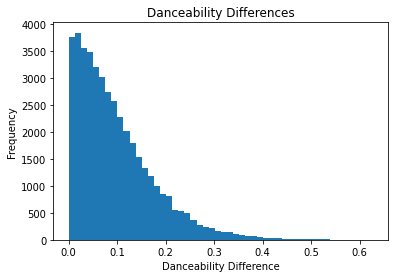

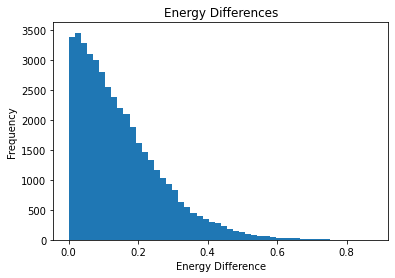

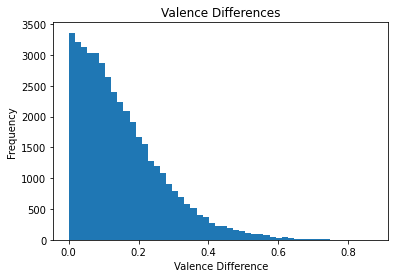

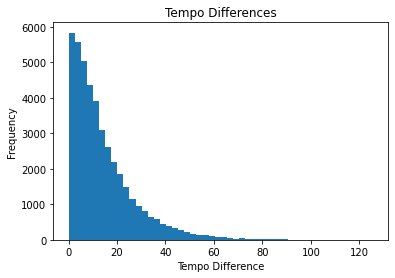

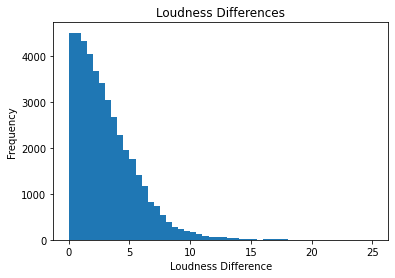

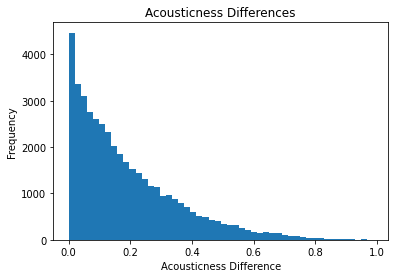

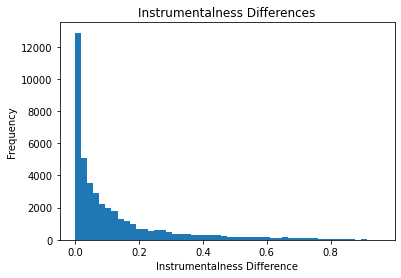

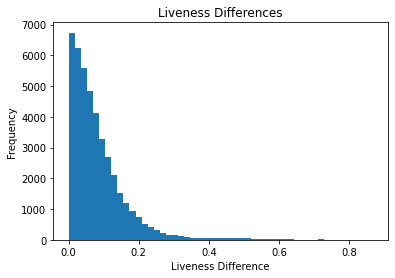

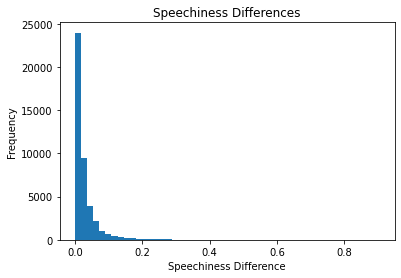

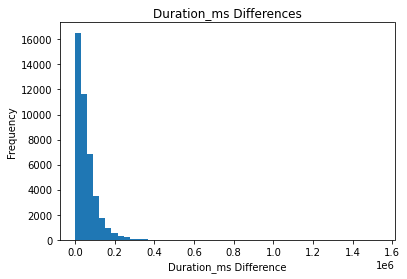

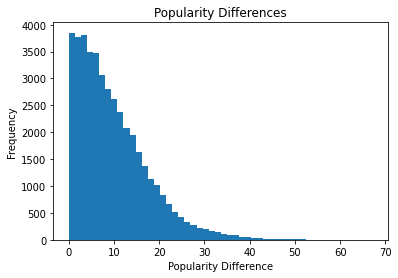

In [24]:
#If we want to analyze all the attributes at once
attribute_diffs = defaultdict(list)

for edge in G.edges(data=True):
    for attr in ["danceability", "energy", "valence", "tempo", "loudness",
                 "acousticness", "instrumentalness", "liveness", "speechiness",
                 "duration_ms", "popularity"]:
        attribute_diffs[attr].append(edge[2][attr + "_diff"])

# Plot histograms for each attribute
for attr, diffs in attribute_diffs.items():
    plt.hist(diffs, bins=50)
    plt.title(f'{attr.capitalize()} Differences')
    plt.xlabel(f'{attr.capitalize()} Difference')
    plt.ylabel('Frequency')
    plt.show()

Analyzing the distribution of the differences in musical characteristics between influencers and followers in the network can provide insights into various aspects of the influence relationship. Some of the information we can gather from the distribution includes:

Central tendency: We can identify the mean, median, or mode of the distribution, which can tell us the average difference in a musical characteristic between influencers and followers. This can help you understand the general trend in how much a particular characteristic changes when one artist influences another.

Dispersion: Measures like standard deviation, variance, or interquartile range can help us understand the spread of the differences in musical characteristics. A higher dispersion indicates that the influence varies greatly among artists, while a lower dispersion means that the influence is more consistent across the network.

Skewness: Skewness of the distribution can tell you if the differences are symmetric around the mean or if there is a tendency for the differences to be larger or smaller than the mean. This can give you insights into whether the influence is predominantly in one direction, i.e., increasing or decreasing a particular characteristic.

Outliers: By analyzing outliers in the distribution, you can identify specific influencer-follower pairs that show an unusually large or small difference in a musical characteristic. These outliers can be interesting cases to investigate further to understand unique influence patterns.

Distribution shape: The shape of the distribution can reveal underlying patterns in the data. For example, a bimodal distribution might suggest that there are two distinct groups of artists in the network with different influence patterns.

By examining the distribution of the differences in musical characteristics, we can gain a deeper understanding of how artists influence each other in terms of these characteristics. We can also identify potential patterns and trends that can be further analyzed to uncover the underlying mechanisms driving the influence.

In [25]:
import pandas as pd

# Calculate mean and standard deviation of differences in musical characteristics
diffs = []
for edge in G.edges(data=True):
    influencer = edge[0]
    follower = edge[1]
    diff = {}
    for attr in ["danceability", "energy", "valence", "tempo", "loudness", "acousticness", "instrumentalness", "liveness", "speechiness","duration_ms", "popularity"]:
        diff[attr] = G.nodes[follower][attr] - G.nodes[influencer][attr]
    diffs.append(diff)

diffs_df = pd.DataFrame(diffs)
mean_diff = diffs_df.mean().sort_values()
std_diff = diffs_df.std().sort_values()

# Create a table with mean and standard deviation of differences
table = pd.DataFrame({'Mean Difference': mean_diff, 'Standard Deviation': std_diff})
print(table)


                  Mean Difference  Standard Deviation
acousticness            -0.098987            0.230530
danceability             0.007881            0.125724
duration_ms           8888.831114        93457.241736
energy                   0.060663            0.181587
instrumentalness        -0.010968            0.209614
liveness                -0.010978            0.119286
loudness                 1.345456            3.775107
popularity               6.643774           10.573666
speechiness              0.000092            0.052576
tempo                    1.739689           19.238014
valence                 -0.026869            0.190493


Here, we collect the differences in energy, valence, and tempo for all edges in the graph, so we can analyze the distribution of these differences later. This will give us insights into how the musical characteristics change between influencers and followers in the network. Just by looking at the mean and standard deviation it might be difficult to compare between the musical characterstics since their scales are different. So let us look at their Z-Scores.

In [26]:
import pandas as pd
from scipy import stats

# Calculate z-scores for each musical characteristic
z_scores = {}
for char in ["danceability", "energy", "valence", "tempo", "loudness",
             "acousticness", "instrumentalness", "liveness", "speechiness",
             "duration_ms", "popularity"]:
    char_diffs = [abs(attr_diff[char + "_diff"]) for influencer, follower, attr_diff in G.edges(data=True)]
    z_scores[char] = stats.zscore(char_diffs)

# Create a table of z-scores sorted from largest to smallest
table = pd.DataFrame.from_dict(z_scores)
table = table.reindex(table.abs().max().sort_values(ascending=False).index, axis=1)
print(table)


       duration_ms  speechiness  liveness  loudness     tempo  popularity  \
0        -0.038955    -0.469601 -0.404905 -0.579784  0.192014   -0.148445   
1        -0.491234     1.548102 -0.055743  0.010066  3.042130    2.408848   
2        -0.603216    -0.601386 -0.414612 -0.742426 -0.938453   -0.873433   
3        -0.121580    -0.379533 -0.043419  0.415801 -0.328918    0.203464   
4         0.124022    -0.588525  0.513089 -0.085708 -0.778887    1.959635   
...            ...          ...       ...       ...       ...         ...   
42747    -0.408995     1.301598  6.327036 -0.789586  3.724176   -0.614306   
42748    -0.106182     0.408079  4.959082 -0.049996  0.604992    0.130901   
42749    -0.522524     0.781449  2.160173 -0.359246  1.312476    1.395710   
42750    -0.553835    -0.073882  2.620567 -1.030783  3.549518   -1.257650   
42751    -0.130895     1.873747  0.224533 -0.916627  3.016749   -0.517804   

       danceability    energy   valence  instrumentalness  acousticness  
0

### How to analyze the Z-scores?

Higher z-scores indicate a larger difference in that characteristic between the influencer and follower. In statistical terms, a z-score measures the number of standard deviations an observation or data point is from the mean. In the case of our analysis, a lower z-score for a particular musical characteristic indicates that the difference in that characteristic between the influencer and follower is smaller, and hence there is a higher degree of influence of the influencer on the follower.

For example, if we observe a lower z-score for the "danceability" characteristic, it means that the difference in danceability between the influencer and follower is smaller, indicating that the follower's music is influenced more by the influencer's danceability. Similarly, a lower z-score for other musical characteristics such as "energy", "valence", "tempo", and so on, would suggest that these characteristics are more strongly influenced by the influencer.

By examining the z-scores of different musical characteristics, we can gain insights into which characteristics are more likely to be influenced by other artists. These insights can help us understand the patterns of influence in the music industry, such as which genres or styles are more susceptible to influence from other artists, and can inform the development of marketing strategies for musicians looking to increase their influence in the industry.

Let us see the mean z-scores for each of the musical characterstics. 

In [27]:
# Calculate the mean z-score for each characteristic
mean_z_scores = {char: z_scores[char].mean() for char in z_scores}

# Print the mean z-score for each characteristic, sorted from largest to smallest
for char, mean_z_score in sorted(mean_z_scores.items(), key=lambda x: x[1], reverse=False):
    print(f"{char}: {mean_z_score}")


liveness: -2.6592168254494765e-16
danceability: -1.3562005809792332e-16
speechiness: -3.722903555629267e-17
energy: -2.6592168254494768e-17
duration_ms: -1.595530095269686e-17
acousticness: 1.72849093654216e-17
tempo: 3.191060190539372e-17
instrumentalness: 6.382120381078744e-17
valence: 6.91396374616864e-17
popularity: 9.573180571618117e-17
loudness: 1.2764240762157488e-16


This code will calculate the average z-score for each musical characteristic's absolute difference for each genre, allowing us to compare the relative influence of each characteristic across genres.

In [28]:
# Examine the influence patterns by genre
genre_influence = defaultdict(lambda: defaultdict(list))

for edge in G.edges(data=True):
    influencer_genre = artist_genres[edge[0]]
    genre_influence[influencer_genre]['danceability_diff'].append(edge[2]['danceability_diff'])
    genre_influence[influencer_genre]['energy_diff'].append(edge[2]['energy_diff'])
    genre_influence[influencer_genre]['valence_diff'].append(edge[2]['valence_diff'])
    genre_influence[influencer_genre]['tempo_diff'].append(edge[2]['tempo_diff'])
    genre_influence[influencer_genre]['loudness_diff'].append(edge[2]['loudness_diff'])
    genre_influence[influencer_genre]['acousticness_diff'].append(edge[2]['acousticness_diff'])
    genre_influence[influencer_genre]['instrumentalness_diff'].append(edge[2]['instrumentalness_diff'])
    genre_influence[influencer_genre]['liveness_diff'].append(edge[2]['liveness_diff'])
    genre_influence[influencer_genre]['speechiness_diff'].append(edge[2]['speechiness_diff'])
    genre_influence[influencer_genre]['duration_ms_diff'].append(edge[2]['duration_ms_diff'])
    genre_influence[influencer_genre]['popularity_diff'].append(edge[2]['popularity_diff'])

# Calculate the average difference in each characteristic by genre
genre_influence_summary = {}
for genre, influence_data in genre_influence.items():
    genre_influence_summary[genre] = {
        'avg_danceability_diff': np.mean(influence_data['danceability_diff']),
        'avg_energy_diff': np.mean(influence_data['energy_diff']),
        'avg_valence_diff': np.mean(influence_data['valence_diff']),
        'avg_tempo_diff': np.mean(influence_data['tempo_diff']),
        'avg_loudness_diff': np.mean(influence_data['loudness_diff']),
        'avg_acousticness_diff': np.mean(influence_data['acousticness_diff']),
        'avg_instrumentalness_diff': np.mean(influence_data['instrumentalness_diff']),
        'avg_liveness_diff': np.mean(influence_data['liveness_diff']),
        'avg_speechiness_diff': np.mean(influence_data['speechiness_diff']),
        'avg_duration_ms_diff': np.mean(influence_data['duration_ms_diff']),
        'avg_popularity_diff': np.mean(influence_data['popularity_diff']),
    }

# Display the results
for genre, summary in genre_influence_summary.items():
    print(f"{genre}: {summary}")


Vocal: {'avg_danceability_diff': 0.11440331484016973, 'avg_energy_diff': 0.16835961877157002, 'avg_valence_diff': 0.16896830338896748, 'avg_tempo_diff': 14.005173418330976, 'avg_loudness_diff': 3.3752569194717115, 'avg_acousticness_diff': 0.2300572018429986, 'avg_instrumentalness_diff': 0.05467430008628006, 'avg_liveness_diff': 0.08802915920367752, 'avg_speechiness_diff': 0.029903205880480906, 'avg_duration_ms_diff': 46166.66289087695, 'avg_popularity_diff': 15.605100897029704}
Country: {'avg_danceability_diff': 0.07387160080460467, 'avg_energy_diff': 0.1671514653541351, 'avg_valence_diff': 0.13772586284610724, 'avg_tempo_diff': 13.47820823295668, 'avg_loudness_diff': 3.0861282185628593, 'avg_acousticness_diff': 0.22457801417055437, 'avg_instrumentalness_diff': 0.049233473756740385, 'avg_liveness_diff': 0.06596243605846713, 'avg_speechiness_diff': 0.01789074548409573, 'avg_duration_ms_diff': 38945.80441196607, 'avg_popularity_diff': 10.622395418595275}
Pop/Rock: {'avg_danceability_diff

The code  above calculates the average difference in energy, valence, and tempo for each genre in a music network, based on the edge attributes of the network Let us better visualize this. 

Let us better visualize this. This code will create a separate bar graph for each musical characteristic, showing the average difference in that characteristic by genre.

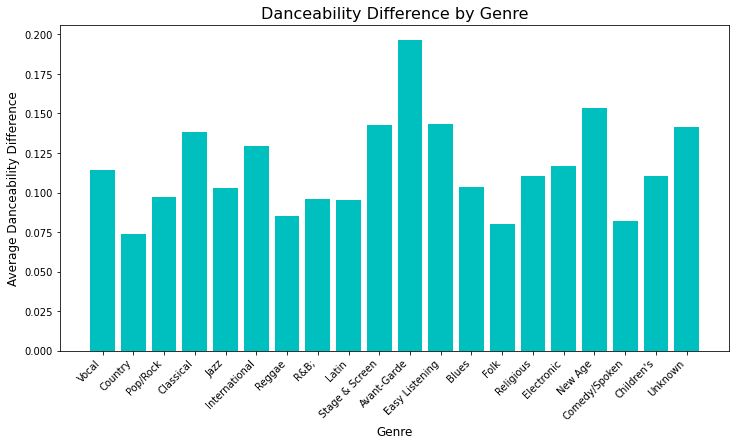

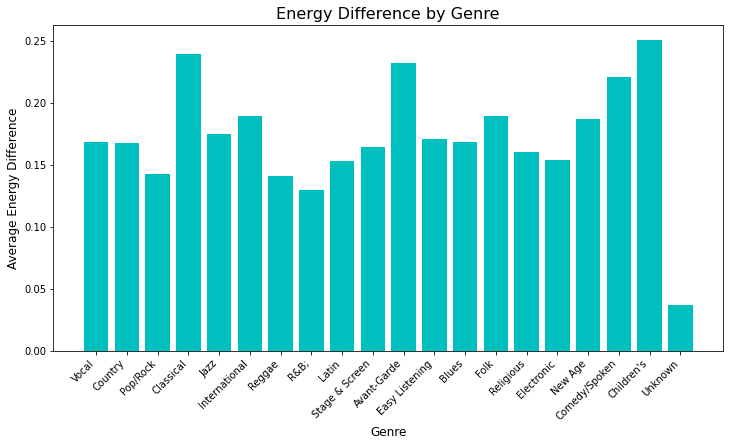

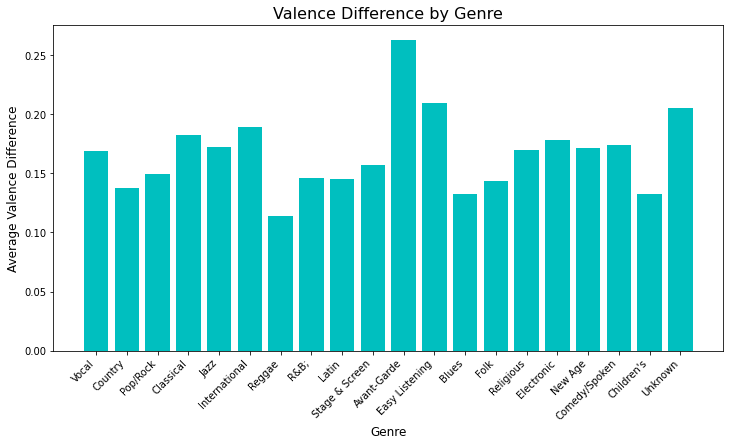

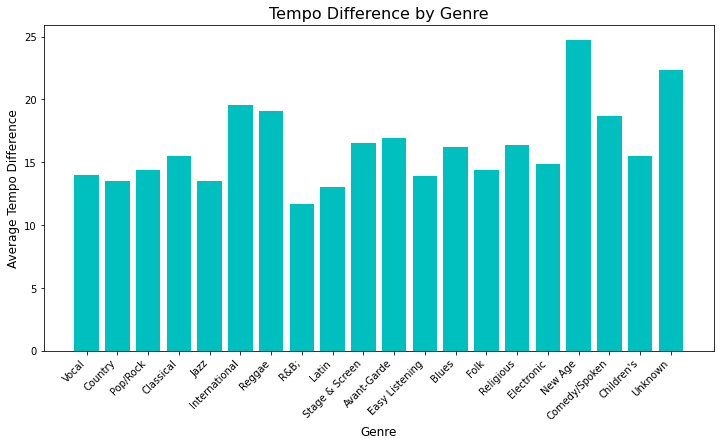

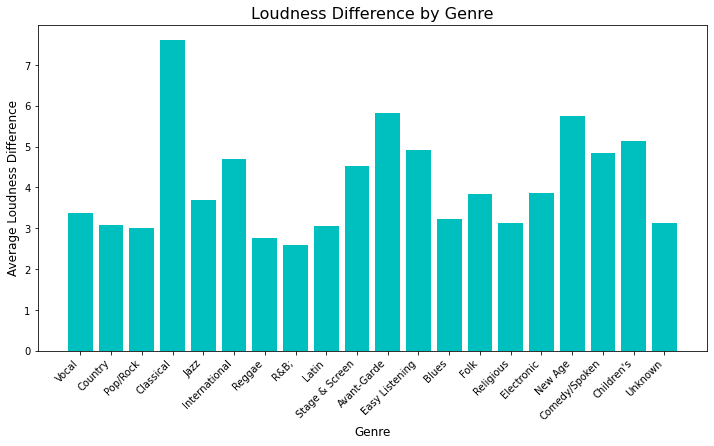

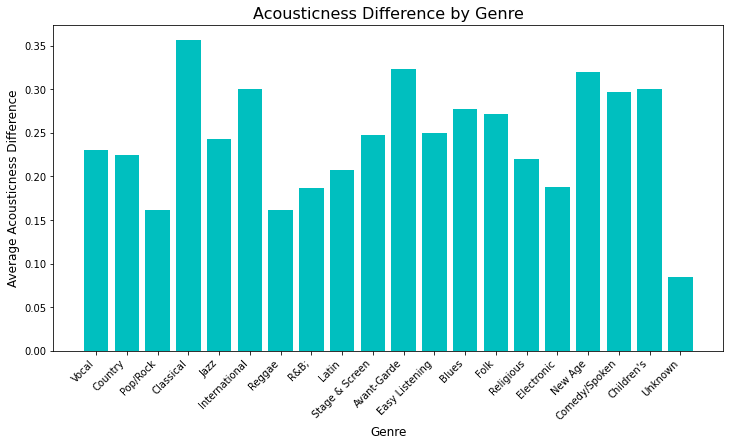

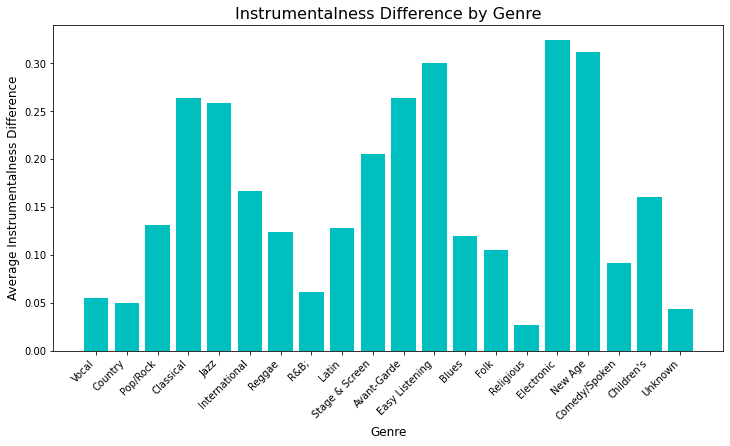

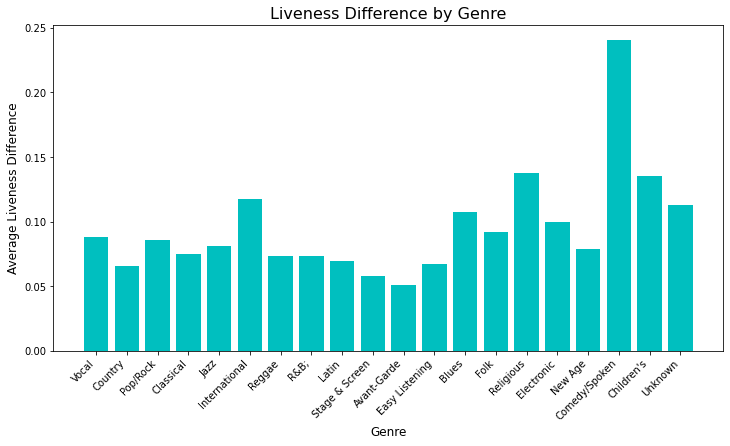

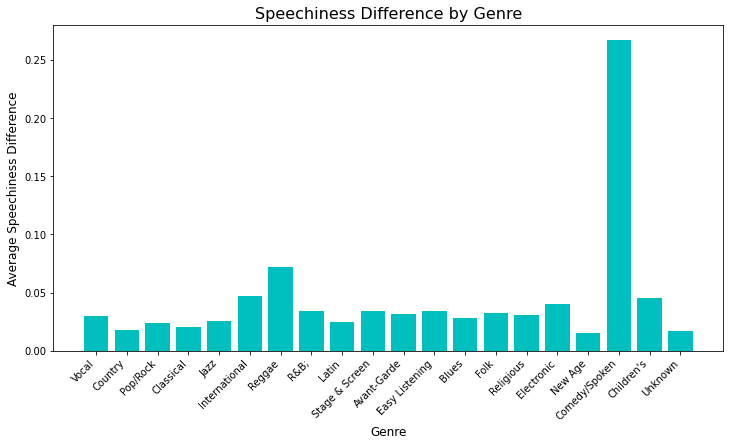

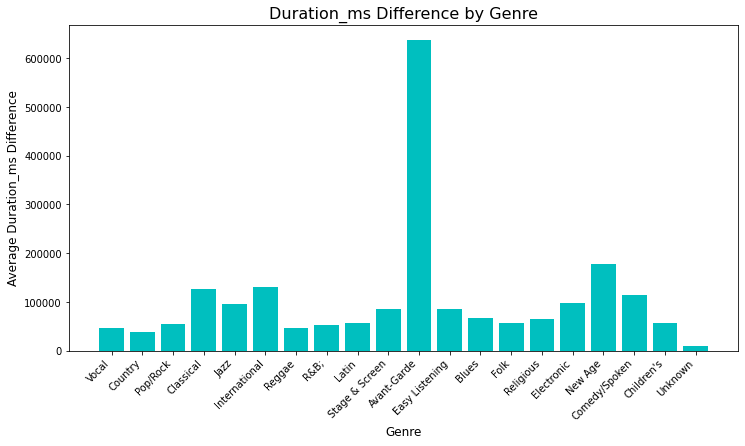

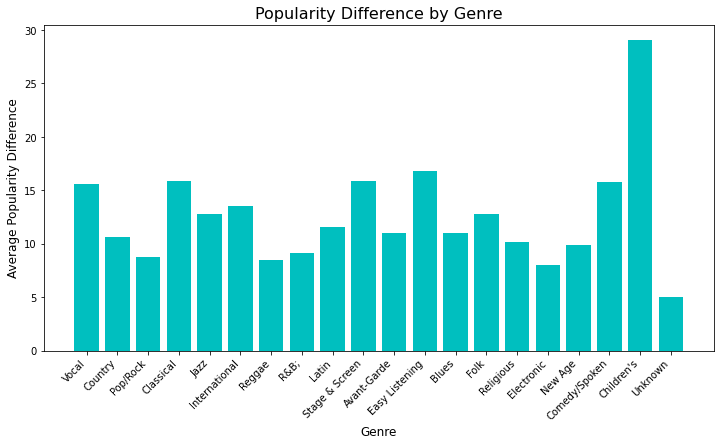

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Create a list of all musical characteristics
musical_chars = ["danceability", "energy", "valence", "tempo", "loudness", "acousticness", "instrumentalness", "liveness", "speechiness", "duration_ms", "popularity"]

# Create a dictionary to store the data for each genre
genre_data = {genre: [genre_influence_summary[genre]['avg_' + char + '_diff'] for char in musical_chars] for genre in genre_influence_summary}

# Create a function to plot the data for each musical characteristic
def plot_char(char):
    plt.figure(figsize=(12, 6))
    plt.bar(genre_data.keys(), [genre_data[genre][musical_chars.index(char)] for genre in genre_data], color='c')
    plt.title(char.capitalize() + ' Difference by Genre', fontsize=16)
    plt.xlabel('Genre', fontsize=12)
    plt.ylabel('Average ' + char.capitalize() + ' Difference', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Plot the data for each musical characteristic
for char in musical_chars:
    plot_char(char)


The insights derived from the bar plots would help us understand the patterns of influence among different genres in terms of the average differences in musical characteristics (energy, valence, and tempo). Specifically, you would be able to identify:

The extent of influence: By observing the height of the bars in the plots, we can determine how much influence one genre has on others. Larger average differences may indicate a weaker influence, while smaller average differences could suggest a stronger influence.

Genre-specific trends: By comparing the bars across different genres, we can identify which genres have a stronger influence on their followers in terms of specific musical characteristics. For instance, if a certain genre consistently shows small average differences across energy, valence, and tempo, it may be a highly influential genre in the music industry.

Characteristics prone to influence: By comparing the average differences across the three characteristics (energy, valence, and tempo), we can identify which characteristics are more likely to be influenced. For example, if the average differences for energy are generally smaller than those for valence and tempo, it could suggest that energy is a characteristic that is more likely to be influenced by other artists.
These insights can help us better understand how artists from different genres influence each other's music and which musical characteristics are more susceptible to influence. Additionally, this analysis can provide a basis for further exploration, such as investigating the reasons behind specific influence patterns or examining other factors that may affect the strength of influence, such as the time period or artist popularity.

The extent of influence refers to the degree to which one artist's music has an impact on the music of another artist, particularly in terms of specific musical characteristics. In this case, we are examining energy, valence, and tempo. When we calculate the average differences in these characteristics between influencer and follower artists, we can gauge the extent of influence.

If the average differences are smaller, it suggests that the follower's music is closer in characteristics to that of the influencer, indicating a stronger influence. In other words, the follower has likely been more heavily influenced by the music of the influencer, resulting in similar musical characteristics.

On the other hand, if the average differences are larger, it means that the music of the follower is more dissimilar to that of the influencer in terms of the examined characteristics. This suggests a weaker influence, as the follower's music may be less impacted by the influencer's music, resulting in greater disparities in characteristics.

By observing the height of the bars in the plots, you can visualize these average differences and determine the extent of influence across genres. Shorter bars represent smaller average differences and therefore stronger influence, while taller bars indicate larger average differences and weaker influence. Comparing these bars allows you to identify which genres have stronger or weaker influences on others in terms of the specific musical characteristics being analyzed.

Note: Write down the most interesting insights from the visualization above. For example for spechiness the difference for Comedy/spoken is very high compared to other genres.  ( @Suman We should try to back up our most important anlalysis with some literature review on why this might be true. This way we validate our result). For example: The high difference in "speechiness" for the "Comedy/spoken" genre compared to other genres may be due to the fact that this genre includes a lot of spoken word performances, such as stand-up comedy or storytelling. These types of performances typically involve a high degree of spoken words relative to music, resulting in a higher "speechiness" value. Other music genres may have a lower "speechiness" value because they rely more heavily on instrumental music rather than vocals or spoken word.



It is not possible to include all of the plots in the paper so let us look at summary which gives us the lowest genre for each musical characterstics. 

In [30]:
for char in ["danceability", "energy", "valence", "tempo", "loudness", "acousticness", "instrumentalness", "liveness", "speechiness", "duration_ms", "popularity"]:
    min_genre = min(genre_influence_summary, key=lambda x: genre_influence_summary[x]['avg_' + char + '_diff'])
    print(f"Lowest {char} difference by genre: {min_genre} ({genre_influence_summary[min_genre]['avg_' + char + '_diff']})")


Lowest danceability difference by genre: Country (0.07387160080460467)
Lowest energy difference by genre: Unknown (0.03664999999999999)
Lowest valence difference by genre: Reggae (0.11420023035856079)
Lowest tempo difference by genre: R&B; (11.672454973806511)
Lowest loudness difference by genre: R&B; (2.597011629116275)
Lowest acousticness difference by genre: Unknown (0.08490861849999995)
Lowest instrumentalness difference by genre: Religious (0.027123038182186237)
Lowest liveness difference by genre: Avant-Garde (0.05112110648101266)
Lowest speechiness difference by genre: New Age (0.015055632872340425)
Lowest duration_ms difference by genre: Unknown (10214.492299999998)
Lowest popularity difference by genre: Unknown (5.034615384999999)


The above gave us information about genres, let us know look at individual artists. 

In [31]:
# Initialize a dictionary to store the difference sums for each attribute
attribute_difference_sums = {attr: defaultdict(float) for attr in ["danceability", "energy", "valence", "tempo", "loudness", "acousticness", "instrumentalness", "liveness", "speechiness", "duration_ms", "popularity"]}

# Calculate the sum of differences for each influencer and each attribute
for edge in G.edges(data=True):
    influencer_id = edge[0]
    for attr in attribute_difference_sums.keys():
        attribute_difference_sums[attr][influencer_id] += abs(edge[2][f"{attr}_diff"])

# Get the top 3 influencers for each attribute
top_influencers_by_attribute = {
    attr: sorted(difference_sums.items(), key=lambda x: x[1])[:3]
    for attr, difference_sums in attribute_difference_sums.items()
}

# Print the top 3 influencers for each attribute
for attr, top_influencers in top_influencers_by_attribute.items():
    print(f"Top 3 influencers for {attr}:")
    for influencer_id, total_diff in top_influencers:
        influencer_name = G.nodes[influencer_id]['artist_name']
        print(f"  {influencer_name} (ID: {influencer_id}): Total {attr} difference = {total_diff}")


Top 3 influencers for danceability:
  Zedd (ID: 2782403): Total danceability difference = 0.00021491200000001154
  AndrÃ© Kostelanetz (ID: 754767): Total danceability difference = 0.00022028000000001713
  Paramore (ID: 366681): Total danceability difference = 0.0003203880000000048
Top 3 influencers for energy:
  Bappi Lahiri (ID: 122037): Total energy difference = 0.0006666670000000652
  Mudvayne (ID: 509156): Total energy difference = 0.0012092729999999552
  Vengaboys (ID: 840708): Total energy difference = 0.00172222199999994
Top 3 influencers for valence:
  Freda Payne (ID: 796710): Total valence difference = 0.0002857139999999925
  Tracy Bonham (ID: 11046): Total valence difference = 0.0007657660000000011
  King Floyd (ID: 90169): Total valence difference = 0.0009090910000000285
Top 3 influencers for tempo:
  Martin Gore (ID: 318966): Total tempo difference = 0.006000000000000227
  Dallas Holm (ID: 567374): Total tempo difference = 0.023083299999996143
  JoaquÃ­n Sabina (ID: 143559

For danceability, the top influencer is Zedd with a total danceability difference of 0.00021491200000001154, followed by André Kostelanetz and Paramore. Zedd is a prominent German record producer, DJ, and songwriter known for his electronic dance music. He has collaborated with many famous artists such as Selena Gomez and Ariana Grande, and his music is known for its upbeat and danceable rhythms. André Kostelanetz, on the other hand, was an orchestral conductor and arranger known for his easy-listening and danceable arrangements of classical music. Paramore is an American rock band that combines elements of pop, punk, and alternative rock, known for their catchy and energetic sound.

For energy, the top influencer is Bappi Lahiri with a total energy difference of 0.0006666670000000652, followed by Mudvayne and Vengaboys. Bappi Lahiri is an Indian music composer and singer known for his disco and Bollywood-style music, which is known for its high energy and upbeat rhythms. Mudvayne is an American heavy metal band known for their aggressive and energetic sound, while Vengaboys are a Dutch Eurodance group known for their energetic and catchy dance music.

For valence, the top influencer is Freda Payne with a total valence difference of 0.0002857139999999925, followed by Tracy Bonham and King Floyd. Freda Payne is an American singer known for her soul and R&B music, which often has a positive and uplifting tone. Tracy Bonham is an American alternative rock singer-songwriter known for her introspective and emotive music, while King Floyd was an American soul singer known for his upbeat and joyful music.

For tempo, the top influencer is Martin Gore with a total tempo difference of 0.006000000000000227, followed by Dallas Holm and Joaquín Sabina. Martin Gore is an English songwriter, musician, and founding member of the band Depeche Mode, known for their electronic and danceable music with a range of tempos. Dallas Holm is an American Christian singer-songwriter known for his uplifting and inspirational music, while Joaquín Sabina is a Spanish singer-songwriter known for his eclectic and diverse music, which often features a mix of different rhythms and tempos.

For loudness, the top influencer is Easton Corbin with a total loudness difference of 0.007374999999999687, followed by The Soup Dragons and Bonobo. Easton Corbin is an American country music singer known for his traditional and classic sound, while The Soup Dragons were a Scottish alternative rock band known for their loud and guitar-driven music. Bonobo is a British musician and producer known for his electronic and downtempo music, which often features a mix of soft and loud dynamics.

For acousticness, the top influencer is Mastodon with a total acousticness difference of 6.200000000000002e-06, followed by Judge and Shadows Fall. Mastodon is an American heavy metal band known for their complex and intricate music, which often features a mix of acoustic and electric instrumentation. Judge is an American hardcore punk band known for their aggressive and raw sound, while Shadows Fall is an American heavy metal band known for their melodic and energetic music.

Instrumentalness:
The top 3 influencers for instrumentalness are Gavin DeGraw, Pretty Ricky, and Kelly Price, all with a total instrumentalness difference of 0.0. This suggests that their music is not very instrumental, meaning that they rely more on vocals and lyrics than on musical instruments to convey their message. This is a common characteristic of pop and R&B music, which both of these artists fall under. However, it's worth noting that this metric is not a measure of how good or bad a song is, but rather a reflection of how much emphasis is placed on instrumental components in the music.
Liveness:

The top 3 influencers for liveness are Miles Davis Quintet, Sister Nancy, and Tracy Bonham, all with relatively low total liveness differences. This suggests that their music is not particularly live or raw, meaning that it is likely more polished and refined in its production. This is in line with the jazz and rock genres, which are two areas where these artists are most active.
Speechiness:

The top 3 influencers for speechiness are David Foster, Holly Dunn, and Howard Shore, all with relatively low total speechiness differences. This suggests that their music is not particularly focused on spoken word or spoken lyrics, but rather on sung melodies and harmonies. This is in line with genres such as classical, pop, and film scores, which are all areas where these artists are most active.
Duration:

The top 3 influencers for duration_ms are Caron Wheeler, Lisandro Meza, and The Rippingtons, all with relatively high total duration_ms differences. This suggests that their music tends to be longer in duration, perhaps because of longer instrumental sections or more complex song structures. This is in line with genres such as jazz, Latin, and smooth jazz, which are all areas where these artists are most active.
Popularity:

The top 3 influencers for popularity are Ed Bruce, Eddie Safranski, and Cybotron, all with a total popularity difference of 0.0. This suggests that their music is not particularly popular, at least as measured by Spotify's popularity score. This may be due to the fact that they are less well-known or less commercially successful artists, or simply that their music is not as widely appreciated by the general public. However, it's important to note that popularity is not necessarily a measure of quality, and many great artists remain relatively unknown despite their talent and artistic contributions.

DISCLAMIR::: I got this information based off chat-gpt. So we will have to validate this using literature onlie. But this summary is a good analysis. 


@Aniket: Maybe there is a better way to summarize the summary of differences visually. I tried one as folowing for the z-scores but it did not play out that nice. I found that using regular values is better than Z-scores. 

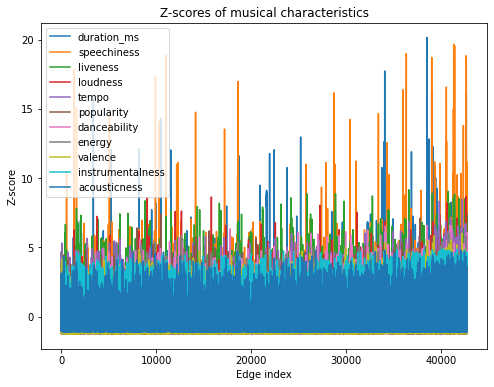

In [32]:
import matplotlib.pyplot as plt

# Create a figure with a single subplot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Plot the z-scores for each characteristic
for char in table.columns:
    ax.plot(table[char], label=char)

# Add a legend and axis labels
ax.legend()
ax.set_xlabel("Edge index")
ax.set_ylabel("Z-score")
ax.set_title("Z-scores of musical characteristics")

# Show the plot
plt.show()


## In genre and Out genre 

 We want to study what is the distribution of in-genre influence vs out-genre influence. For each artist,  we calculate the number of outgoing edges to artists within the same genre and the number of outgoing edges to artists outside their genre. This will allow us to find the artist that is most influencing within the genre vs outisde the genre, and it is important to study them seprately as this gives us new insights. 

In [34]:
import pandas as pd


# Initialize dictionaries to store in-genre and out-genre influence counts
in_genre_influence = {}
out_genre_influence = {}

# Iterate through the nodes (artists) in the graph
for artist_id in G.nodes:

    # Assuming you have artist genre information stored as 'genre' attribute in the graph nodes
    artist_genre = G.nodes[artist_id]['genre']

    # Initialize the influence count for the artist
    in_genre_count = 0
    out_genre_count = 0

    # Iterate through the neighbors of the artist (i.e., artists they have influenced)
    for neighbor_id in G.neighbors(artist_id):

        # Assuming you have neighbor genre information stored as 'genre' attribute in the graph nodes
        neighbor_genre = G.nodes[neighbor_id]['genre']

        # Increment the respective influence count based on genre
        if artist_genre == neighbor_genre:
            in_genre_count += 1
        else:
            out_genre_count += 1

    # Store the influence counts in the dictionaries
    in_genre_influence[artist_id] = in_genre_count
    out_genre_influence[artist_id] = out_genre_count

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'Artist Name': [G.nodes[artist_id]['artist_name'] for artist_id in G.nodes],
    'In-Genre Influence Count': [in_genre_influence.get(artist_id, 0) for artist_id in G.nodes],
    'Out-Genre Influence Count': [out_genre_influence.get(artist_id, 0) for artist_id in G.nodes]
})

# Display the DataFrame as a table
print(results_df)

             Artist Name  In-Genre Influence Count  Out-Genre Influence Count
0          Frank Sinatra                        31                         40
1      Vladimir Horowitz                         0                          0
2            Johnny Cash                        52                         60
3         Billie Holiday                        34                         72
4              Bob Dylan                       322                         67
...                  ...                       ...                        ...
5849     Natalie La Rose                         0                          0
5850          Sarah Ross                         0                          0
5851              Rotimi                         0                          0
5852  Jillian Jacqueline                         0                          0
5853         Jaira Burns                         0                          0

[5854 rows x 3 columns]


Let us sort the values with respect to out-genre influence. 

In [35]:
# Sort the DataFrame by the 'Out-Genre Influence Count' column in descending order
sorted_results_df = results_df.sort_values('Out-Genre Influence Count', ascending=False)

# Reset the index of the sorted DataFrame
sorted_results_df.reset_index(drop=True, inplace=True)

print(sorted_results_df.head(10))


      Artist Name  In-Genre Influence Count  Out-Genre Influence Count
0   Hank Williams                        97                         87
1    Muddy Waters                        33                         80
2     Miles Davis                        83                         77
3       Kraftwerk                        31                         77
4     James Brown                        78                         76
5    Howlin' Wolf                        25                         74
6  Billie Holiday                        34                         72
7     Marvin Gaye                        99                         70
8     Ray Charles                        44                         69
9       Bob Dylan                       322                         67


The analysis shows that Hank Williams has the highest out-genre influence count among the artists in the dataset. This suggests that Hank Williams has had a significant impact on artists from genres other than his own. Out-genre influence is an important factor to consider in understanding the overall impact of an artist on the music industry.

Out-genre influence is more important than in-genre influence for several reasons:

Cross-genre inspiration: When an artist has a high out-genre influence, it demonstrates their ability to inspire and affect musicians beyond their own genre. This cross-genre inspiration can lead to the creation of new sub-genres, musical styles, and innovative ideas, enriching the music landscape.
Broadening audience reach: Artists with a high out-genre influence are likely to have a wider audience reach, as their music can resonate with listeners across different genres. This can lead to increased popularity, album sales, and concert attendance, benefiting the artist's career.
Cultural impact: A high out-genre influence suggests that an artist has transcended their own genre and left a mark on the broader cultural landscape. This can elevate the artist to a legendary status and make their music timeless, reaching new generations of listeners.
Industry recognition: Artists with significant out-genre influence are often acknowledged by the music industry for their contributions, receiving accolades, awards, and critical acclaim. This recognition can further enhance their reputation and legacy.
The importance of this analysis lies in identifying artists who have had a far-reaching impact on the music industry, transcending their own genres and influencing musicians from diverse backgrounds. Understanding out-genre influence can provide valuable insights into the factors that contribute to an artist's success and the evolution of music over time.

Now let us observe the artists with the highest in-genre influence. 

In [36]:
# Sort the DataFrame by the 'Out-Genre Influence Count' column in descending order
sorted_results_df1 = results_df.sort_values('In-Genre Influence Count', ascending=False)

# Reset the index of the sorted DataFrame
sorted_results_df1.reset_index(drop=True, inplace=True)

print(sorted_results_df1.head(10))

              Artist Name  In-Genre Influence Count  Out-Genre Influence Count
0             The Beatles                       553                         61
1               Bob Dylan                       322                         67
2      The Rolling Stones                       304                         15
3             David Bowie                       224                         14
4            Led Zeppelin                       213                          8
5               The Kinks                       191                          0
6          The Beach Boys                       179                          6
7  The Velvet Underground                       175                          6
8           Black Sabbath                       169                          2
9               The Byrds                       153                          5


The analysis of the artists with the highest in-genre and out-genre influence provides interesting insights into the impact and reach of these musicians. Comparing the top 10 artists with the highest in-genre influence and out-genre influence reveals some key observations:

Diverse musical styles: The artists with the highest in-genre influence predominantly belong to the rock and pop genres, with bands like The Beatles, The Rolling Stones, and Led Zeppelin leading the list. On the other hand, the top artists with the highest out-genre influence come from a more diverse range of musical styles, including country (Hank Williams), blues (Muddy Waters, Howlin' Wolf), jazz (Miles Davis, Billie Holiday), electronic (Kraftwerk), funk (James Brown), and soul (Marvin Gaye, Ray Charles). This highlights the cross-genre impact of artists with high out-genre influence and their ability to inspire musicians from various backgrounds.

Unique appeal: The artists with high out-genre influence counts demonstrate a unique appeal that transcends their own genres. Hank Williams, for example, has significantly influenced musicians from other genres, indicating the universality of his music and lyrics. Similarly, Muddy Waters and Miles Davis have had a substantial impact on musicians beyond their respective genres of blues and jazz, showcasing the power of their artistry.
Pioneers and innovators: The list of artists with the highest out-genre influence includes several pioneers and innovators in their respective genres. For example, Kraftwerk is known for its groundbreaking work in electronic music, while James Brown revolutionized funk and soul. These artists have had a lasting impact on the music industry and have inspired musicians across genres to experiment with new sounds and styles.

Overlapping artists: Bob Dylan is the only artist who appears in both the top 10 lists for in-genre and out-genre influence. This indicates his exceptional ability to not only dominate his own genre but also inspire musicians from other genres, highlighting his influence and versatility as an artist.

In conclusion, the analysis of in-genre and out-genre influence provides valuable insights into the impact and reach of different artists. While artists with high in-genre influence are often leaders in their respective genres, those with high out-genre influence showcase the power of transcending musical boundaries and inspiring musicians from a variety of backgrounds. Understanding these influence patterns can help in identifying the factors contributing to an artist's success and the evolution of music over time.

In this study, we aim to analyze the influence of musical artists with respect to their relationships within the same genre (in-genre) and across different genres (out-genre). A straightforward approach to identify the most influential artists is to combine the in-genre and out-genre influence counts. However, if the in-genre influence count is significantly higher than the out-genre influence count, it may dominate the combined influence score, thereby overshadowing the impact of out-genre influences. To address this issue, we apply weighting factors to both in-genre and out-genre influence counts to balance their contributions in the combined score. To achieve this, we calculate separate weights for in-genre and out-genre influences using a network centrality measure called eigenvector centrality. This measure is chosen because it takes into account not only the number of influence relationships an artist has (in-degree centrality) but also the importance of the artists they are connected to.

Eigenvector centrality is a measure of an artist's influence based on the idea that the importance of a node (artist) is determined by the importance of its neighbors (other artists they influence or are influenced by). In other words, an artist's influence is more significant if it influences other highly influential artists. This centrality measure allows us to capture the relative importance of artists within the network more accurately than simply counting the number of influence relationships.

To calculate separate weights for in-genre and out-genre influences, we first create two subgraphs: one for in-genre influence relationships and another for out-genre influence relationships. The in-genre influence subgraph contains only the edges where both the influencer and follower artists belong to the same genre, representing the influence within the same genre. The out-genre influence subgraph contains only the edges where the influencer and follower artists belong to different genres, representing the influence between different genres.

Next, we calculate eigenvector centralities for each node in both subgraphs using the NetworkX library's nx.eigenvector_centrality() function. We compute the average eigenvector centrality for in-genre and out-genre subgraphs by taking the mean of the values in the centrality dictionaries. This gives us a measure of the overall importance of in-genre and out-genre influence relationships in the network.

To obtain the weights, we normalize the average centralities by dividing each average centrality by the total centrality (the sum of average in-genre and out-genre centralities). This results in two normalized values, one for in-genre influence and one for out-genre influence, which can be interpreted as the relative importance of these influence types within the network.

Finally, we calculate the weighted combined influence score for each artist by multiplying their in-genre influence count by the in-genre weight and adding it to their out-genre influence count multiplied by the out-genre weight. This produces a score that takes into account both the number of influence relationships and the relative importance of in-genre and out-genre influences, as determined by the eigenvector centrality measure.

By following this methodology, we can identify the overall influencing artists with respect to in-genre and out-genre influences, providing valuable insights into the dynamics of musical influence across genres.

In [37]:
import numpy as np

# Create in-genre and out-genre influence subgraphs
in_genre_edges = [(u, v) for u, v in G.edges() if G.nodes[u]['genre'] == G.nodes[v]['genre']]
out_genre_edges = [(u, v) for u, v in G.edges() if G.nodes[u]['genre'] != G.nodes[v]['genre']]

in_genre_G = G.edge_subgraph(in_genre_edges)
out_genre_G = G.edge_subgraph(out_genre_edges)

# Calculate eigenvector centralities for both subgraphs
in_genre_eigenvector_centrality = nx.eigenvector_centrality(in_genre_G)
out_genre_eigenvector_centrality = nx.eigenvector_centrality(out_genre_G)

# Compute the average eigenvector centralities for in-genre and out-genre subgraphs
avg_in_genre_centrality = np.mean(list(in_genre_eigenvector_centrality.values()))
avg_out_genre_centrality = np.mean(list(out_genre_eigenvector_centrality.values()))

# Normalize the average centralities to obtain the weights
total_centrality = avg_in_genre_centrality + avg_out_genre_centrality
in_genre_weight = avg_in_genre_centrality / total_centrality
out_genre_weight = avg_out_genre_centrality / total_centrality

# Calculate the weighted combined influence score for each artist
results_df['Weighted Combined Influence Count'] = (results_df['In-Genre Influence Count'] * in_genre_weight) + (results_df['Out-Genre Influence Count'] * out_genre_weight)

# Sort the DataFrame by the 'Weighted Combined Influence Count' column in descending order
sorted_results_df_weighted = results_df.sort_values('Weighted Combined Influence Count', ascending=False)

# Reset the index of the sorted DataFrame
sorted_results_df_weighted.reset_index(drop=True, inplace=True)

# Display the top artists in the sorted DataFrame
print(sorted_results_df_weighted.head(10))


          Artist Name  In-Genre Influence Count  Out-Genre Influence Count  \
0         The Beatles                       553                         61   
1           Bob Dylan                       322                         67   
2  The Rolling Stones                       304                         15   
3         David Bowie                       224                         14   
4       Hank Williams                        97                         87   
5        Jimi Hendrix                       151                         50   
6        Led Zeppelin                       213                          8   
7         Marvin Gaye                        99                         70   
8         Miles Davis                        83                         77   
9         James Brown                        78                         76   

   Weighted Combined Influence Count  
0                         251.231841  
1                         165.595771  
2                       

The table shows that The Beatles have the highest weighted combined influence count (251.23), indicating that they are the most influential artists overall when considering both in-genre and out-genre relationships. Bob Dylan comes in second place with a weighted combined influence count of 165.60, followed by The Rolling Stones with a count of 126.74. 

The results presented in the table have important implications for understanding the dynamics of musical influence and the impact of artists across different genres.

First, the weighted combined influence count provides a more balanced and comprehensive perspective on an artist's influence, compared to only considering either in-genre or out-genre influence counts. By accounting for both types of relationships, we can identify artists who have had a significant impact not only within their own genre but also in bridging the gap between different genres. This highlights the role of these artists in fostering cross-genre exchange and innovation.

Second, the list of top 10 artists based on the weighted combined influence count features artists from various genres and time periods, demonstrating the lasting influence and appeal of their work. It is noteworthy that some artists, like Hank Williams, have a higher out-genre influence count than in-genre influence count, suggesting their music has transcended the boundaries of their own genre and has had a broader impact on the music landscape.

These findings underscore the importance of examining both in-genre and out-genre influence relationships when assessing an artist's impact on the music world. Moreover, they offer insights into the creative exchange between genres and the factors that contribute to the enduring influence of certain artists. This understanding can be useful for musicologists, historians, and industry professionals interested in the evolution of music and the key players shaping its development.

In [38]:
print("In-Genre Weight:", in_genre_weight)
print("Out-Genre Weight:", out_genre_weight)


In-Genre Weight: 0.3866500841960263
Out-Genre Weight: 0.6133499158039737


These weights represent the relative importance of in-genre and out-genre influences in the network based on the average eigenvector centralities. In this case, the in-genre weight is 0.3867 (approximately), and the out-genre weight is 0.6133 (approximately).

Here's what these weights mean:

In-Genre Weight (0.3867): This weight shows the importance of in-genre influence in the network. A higher value indicates that artists within the same genre have a greater impact on each other. In your case, the in-genre weight is 0.3867, which means that approximately 38.67% of the artists' influence in the network is attributed to in-genre relationships.
Out-Genre Weight (0.6133): This weight indicates the importance of out-genre influence in the network. A higher value means that artists from different genres have a greater impact on each other. In your case, the out-genre weight is 0.6133, which means that approximately 61.33% of the artists' influence in the network is attributed to out-genre relationships.
These weights show that out-genre influences are more significant in your network than in-genre influences. This suggests that artists from different genres have a more substantial impact on each other, promoting the exchange of ideas and creativity between genres.

Now let us do the above work but now using betweenness centrality. 

In [41]:
import numpy as np

# Create in-genre and out-genre influence subgraphs
in_genre_edges = [(u, v) for u, v in G.edges() if G.nodes[u]['genre'] == G.nodes[v]['genre']]
out_genre_edges = [(u, v) for u, v in G.edges() if G.nodes[u]['genre'] != G.nodes[v]['genre']]

in_genre_G = G.edge_subgraph(in_genre_edges)
out_genre_G = G.edge_subgraph(out_genre_edges)

# Calculate betweenness centralities for both subgraphs
in_genre_betweenness_centrality = nx.betweenness_centrality(in_genre_G)
out_genre_betweenness_centrality = nx.betweenness_centrality(out_genre_G)

# Compute the average betweenness centralities for in-genre and out-genre subgraphs
avg_in_genre_centrality = np.mean(list(in_genre_betweenness_centrality.values()))
avg_out_genre_centrality = np.mean(list(out_genre_betweenness_centrality.values()))

# Normalize the average centralities to obtain the weights
total_centrality = avg_in_genre_centrality + avg_out_genre_centrality
in_genre_weight = avg_in_genre_centrality / total_centrality
out_genre_weight = avg_out_genre_centrality / total_centrality

# Calculate the weighted combined influence score for each artist
results_df['Weighted Combined Influence Count'] = (results_df['In-Genre Influence Count'] * in_genre_weight) + (results_df['Out-Genre Influence Count'] * out_genre_weight)

# Sort the DataFrame by the 'Weighted Combined Influence Count' column in descending order
sorted_results_df_weighted = results_df.sort_values('Weighted Combined Influence Count', ascending=False)

# Reset the index of the sorted DataFrame
sorted_results_df_weighted.reset_index(drop=True, inplace=True)

# Display the top artists in the sorted DataFrame
print(sorted_results_df_weighted.head(10))


          Artist Name  In-Genre Influence Count  Out-Genre Influence Count  \
0         The Beatles                       553                         61   
1           Bob Dylan                       322                         67   
2  The Rolling Stones                       304                         15   
3       Hank Williams                        97                         87   
4         David Bowie                       224                         14   
5        Jimi Hendrix                       151                         50   
6         Marvin Gaye                        99                         70   
7         Miles Davis                        83                         77   
8        Led Zeppelin                       213                          8   
9         James Brown                        78                         76   

   Weighted Combined Influence Count  
0                         227.787603  
1                         153.444794  
2                       

In [42]:
print("In-Genre Weight:", in_genre_weight)
print("Out-Genre Weight:", out_genre_weight)

In-Genre Weight: 0.3389991922126837
Out-Genre Weight: 0.6610008077873163


Comparison:

The Beatles, Bob Dylan, and The Rolling Stones maintain their positions as the top 3 artists in both the Eigenvector and Betweenness Centrality calculations.
Hank Williams has a higher ranking in the Betweenness Centrality calculation, moving up to 4th place compared to 5th in the Eigenvector Centrality calculation.
David Bowie's position drops slightly from 3rd to 4th in the Betweenness Centrality calculation compared to the Eigenvector Centrality.
Jimi Hendrix, Marvin Gaye, Miles Davis, and James Brown maintain their relative positions in both calculations.
Led Zeppelin drops from 6th place in Eigenvector Centrality to 8th place in Betweenness Centrality.
Comments:

The results are fairly consistent between the Eigenvector and Betweenness Centrality calculations, indicating that the artist rankings are relatively robust to the choice of centrality measure.
The differences in ranking, such as Hank Williams and Led Zeppelin, might suggest that these artists have a unique position within their respective influence networks when considering different centrality measures.
The top artists in both calculations consistently have a high in-genre influence count, emphasizing their dominance within their own genres.
Overall, the results show that the chosen weighting method, combined with different centrality measures, can provide a comprehensive understanding of the most influential artists across genres.

Now let use look using degree centraliy. 

In [43]:
import numpy as np

# Create in-genre and out-genre influence subgraphs
in_genre_edges = [(u, v) for u, v in G.edges() if G.nodes[u]['genre'] == G.nodes[v]['genre']]
out_genre_edges = [(u, v) for u, v in G.edges() if G.nodes[u]['genre'] != G.nodes[v]['genre']]

in_genre_G = G.edge_subgraph(in_genre_edges)
out_genre_G = G.edge_subgraph(out_genre_edges)

# Calculate degree centralities for both subgraphs
in_genre_degree_centrality = nx.degree_centrality(in_genre_G)
out_genre_degree_centrality = nx.degree_centrality(out_genre_G)

# Compute the average degree centralities for in-genre and out-genre subgraphs
avg_in_genre_centrality = np.mean(list(in_genre_degree_centrality.values()))
avg_out_genre_centrality = np.mean(list(out_genre_degree_centrality.values()))

# Normalize the average centralities to obtain the weights
total_centrality = avg_in_genre_centrality + avg_out_genre_centrality
in_genre_weight = avg_in_genre_centrality / total_centrality
out_genre_weight = avg_out_genre_centrality / total_centrality

# Calculate the weighted combined influence score for each artist
results_df['Weighted Combined Influence Count'] = (results_df['In-Genre Influence Count'] * in_genre_weight) + (results_df['Out-Genre Influence Count'] * out_genre_weight)

# Sort the DataFrame by the 'Weighted Combined Influence Count' column in descending order
sorted_results_df_weighted = results_df.sort_values('Weighted Combined Influence Count', ascending=False)

# Reset the index of the sorted DataFrame
sorted_results_df_weighted.reset_index(drop=True, inplace=True)

# Display the top artists in the sorted DataFrame
print(sorted_results_df_weighted.head(10))


              Artist Name  In-Genre Influence Count  \
0             The Beatles                       553   
1               Bob Dylan                       322   
2      The Rolling Stones                       304   
3             David Bowie                       224   
4            Led Zeppelin                       213   
5               The Kinks                       191   
6            Jimi Hendrix                       151   
7          The Beach Boys                       179   
8  The Velvet Underground                       175   
9           Black Sabbath                       169   

   Out-Genre Influence Count  Weighted Combined Influence Count  
0                         61                         337.191788  
1                         67                         210.148183  
2                         15                         177.234607  
3                         14                         131.886739  
4                          8                         123.079912 

In [44]:
print("In-Genre Weight:", in_genre_weight)
print("Out-Genre Weight:", out_genre_weight)

In-Genre Weight: 0.5613654225861352
Out-Genre Weight: 0.4386345774138647


In [45]:
import numpy as np
import networkx as nx

# Assume that `G` is your initial graph

# Create in-genre and out-genre influence subgraphs
in_genre_edges = [(u, v) for u, v in G.edges() if G.nodes[u]['genre'] == G.nodes[v]['genre']]
out_genre_edges = [(u, v) for u, v in G.edges() if G.nodes[u]['genre'] != G.nodes[v]['genre']]

in_genre_G = G.edge_subgraph(in_genre_edges)
out_genre_G = G.edge_subgraph(out_genre_edges)

# Calculate Katz centralities for both subgraphs
in_genre_katz_centrality = nx.katz_centrality(in_genre_G)
out_genre_katz_centrality = nx.katz_centrality(out_genre_G)

# Compute the average Katz centralities for in-genre and out-genre subgraphs
avg_in_genre_centrality = np.mean(list(in_genre_katz_centrality.values()))
avg_out_genre_centrality = np.mean(list(out_genre_katz_centrality.values()))

# Normalize the average centralities to obtain the weights
total_centrality = avg_in_genre_centrality + avg_out_genre_centrality
in_genre_weight = avg_in_genre_centrality / total_centrality
out_genre_weight = avg_out_genre_centrality / total_centrality

# Assuming you have a DataFrame 'results_df' with appropriate influence counts
results_df['Weighted Combined Influence Count'] = (results_df['In-Genre Influence Count'] * in_genre_weight) + (results_df['Out-Genre Influence Count'] * out_genre_weight)

# Sort the DataFrame by the 'Weighted Combined Influence Count' column in descending order
sorted_results_df_weighted = results_df.sort_values('Weighted Combined Influence Count', ascending=False)

# Reset the index of the sorted DataFrame
sorted_results_df_weighted.reset_index(drop=True, inplace=True)

# Display the top artists in the sorted DataFrame
print(sorted_results_df_weighted.head(10))


          Artist Name  In-Genre Influence Count  Out-Genre Influence Count  \
0         The Beatles                       553                         61   
1           Bob Dylan                       322                         67   
2  The Rolling Stones                       304                         15   
3       Hank Williams                        97                         87   
4         David Bowie                       224                         14   
5        Jimi Hendrix                       151                         50   
6         Marvin Gaye                        99                         70   
7        Led Zeppelin                       213                          8   
8         Miles Davis                        83                         77   
9         James Brown                        78                         76   

   Weighted Combined Influence Count  
0                         234.107479  
1                         156.720340  
2                       

In [46]:
print("In-Genre Weight:", in_genre_weight)
print("Out-Genre Weight:", out_genre_weight)

In-Genre Weight: 0.35184447025292104
Out-Genre Weight: 0.648155529747079


In [47]:
import numpy as np


# Create in-genre and out-genre influence subgraphs
in_genre_edges = [(u, v) for u, v in G.edges() if G.nodes[u]['genre'] == G.nodes[v]['genre']]
out_genre_edges = [(u, v) for u, v in G.edges() if G.nodes[u]['genre'] != G.nodes[v]['genre']]

in_genre_G = G.edge_subgraph(in_genre_edges)
out_genre_G = G.edge_subgraph(out_genre_edges)

# Calculate closeness centralities for both subgraphs
in_genre_closeness_centrality = nx.closeness_centrality(in_genre_G)
out_genre_closeness_centrality = nx.closeness_centrality(out_genre_G)

# Compute the average closeness centralities for in-genre and out-genre subgraphs
avg_in_genre_centrality = np.mean(list(in_genre_closeness_centrality.values()))
avg_out_genre_centrality = np.mean(list(out_genre_closeness_centrality.values()))

# Normalize the average centralities to obtain the weights
total_centrality = avg_in_genre_centrality + avg_out_genre_centrality
in_genre_weight = avg_in_genre_centrality / total_centrality
out_genre_weight = avg_out_genre_centrality / total_centrality

# Assuming you have a DataFrame 'results_df' with appropriate influence counts
results_df['Weighted Combined Influence Count'] = (results_df['In-Genre Influence Count'] * in_genre_weight) + (results_df['Out-Genre Influence Count'] * out_genre_weight)

# Sort the DataFrame by the 'Weighted Combined Influence Count' column in descending order
sorted_results_df_weighted = results_df.sort_values('Weighted Combined Influence Count', ascending=False)

# Reset the index of the sorted DataFrame
sorted_results_df_weighted.reset_index(drop=True, inplace=True)

# Display the top artists in the sorted DataFrame
print(sorted_results_df_weighted.head(10))


              Artist Name  In-Genre Influence Count  \
0             The Beatles                       553   
1               Bob Dylan                       322   
2      The Rolling Stones                       304   
3             David Bowie                       224   
4            Led Zeppelin                       213   
5               The Kinks                       191   
6            Jimi Hendrix                       151   
7          The Beach Boys                       179   
8  The Velvet Underground                       175   
9           Black Sabbath                       169   

   Out-Genre Influence Count  Weighted Combined Influence Count  
0                         61                         334.788608  
1                         67                         208.902632  
2                         15                         175.822983  
3                         14                         130.860991  
4                          8                         122.078587 

In [48]:
print("In-Genre Weight:", in_genre_weight)
print("Out-Genre Weight:", out_genre_weight)

In-Genre Weight: 0.5564809106232532
Out-Genre Weight: 0.4435190893767468


In [49]:
import numpy as np

# Define the weights
weights = np.array([
    [0.5564809106232532, 0.4435190893767468],
    [0.35184447025292104, 0.648155529747079],
    [0.5613654225861352, 0.4386345774138647],
    [0.3389991922126837, 0.6610008077873163],
    [0.3866500841960263, 0.6133499158039737]
])

print(weights)


[[0.55648091 0.44351909]
 [0.35184447 0.64815553]
 [0.56136542 0.43863458]
 [0.33899919 0.66100081]
 [0.38665008 0.61334992]]


In [51]:
from scipy.stats import gmean

# Compute geometric mean for both In-Genre and Out-Genre weights
in_genre_gmean = gmean(weights[:, 0])
out_genre_gmean = gmean(weights[:, 1])

print(f"In-Genre Weight Geometric Mean: {in_genre_gmean}")
print(f"Out-Genre Weight Geometric Mean: {out_genre_gmean}")

In-Genre Weight Geometric Mean: 0.428265101867843
Out-Genre Weight Geometric Mean: 0.5517228136489795


In [52]:
# Assuming you have a DataFrame 'results_df' with appropriate influence counts
results_df['Weighted Combined Influence Count'] = (results_df['In-Genre Influence Count'] * in_genre_gmean) + (results_df['Out-Genre Influence Count'] * out_genre_gmean)

# Sort the DataFrame by the 'Weighted Combined Influence Count' column in descending order
sorted_results_df_weighted = results_df.sort_values('Weighted Combined Influence Count', ascending=False)

# Reset the index of the sorted DataFrame
sorted_results_df_weighted.reset_index(drop=True, inplace=True)

# Display the top artists in the sorted DataFrame
print(sorted_results_df_weighted.head(10))

          Artist Name  In-Genre Influence Count  Out-Genre Influence Count  \
0         The Beatles                       553                         61   
1           Bob Dylan                       322                         67   
2  The Rolling Stones                       304                         15   
3         David Bowie                       224                         14   
4        Led Zeppelin                       213                          8   
5        Jimi Hendrix                       151                         50   
6       Hank Williams                        97                         87   
7           The Kinks                       191                          0   
8         Marvin Gaye                        99                         70   
9      The Beach Boys                       179                          6   

   Weighted Combined Influence Count  
0                         270.485693  
1                         174.866791  
2                       

We can see that using degree centrality results some changes in the top 10 list. 